In [12]:
import numpy as np
import pandas as pd

from methodology.forecasting import compute_rmse_df, compute_mape_df

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

In [13]:
# Load the data and calculate the inflation rate
cpi_monthly_data = pd.read_csv("methodology/data/cpi_monthly_data.csv", index_col=0)
cpi = cpi_monthly_data[["00"]]
inflation_rate = cpi.pct_change(12).dropna(how="all") * 100
inflation_rate.columns = ["Inflation Rate"]
inflation_rate.index = pd.to_datetime(inflation_rate.index)

## AR Processes

In [14]:
from methodology.ar_forecasts import rolling_ar_forecast, rolling_bic_ar_forecast

#### Fixed Order Models

In [24]:
ar_forecasts = []
for p in [1, 2, 12, 13, 25]:
    ar_forecasts.append(rolling_ar_forecast(inflation_rate, p, n=240, h=12, start="2009-12-01", end="2024-11-01"))
ar_forecasts = pd.concat(ar_forecasts, axis=1)
ar_forecasts.to_csv("results/benchmarks/fixed_order_ar_forecasts.csv")
np.round(compute_rmse_df(ar_forecasts).T, 2)

,1,2,3,4,5,6,7,8,9,10,11,12
AR(1),0.43,0.68,0.91,1.15,1.41,1.66,1.93,2.19,2.45,2.68,2.92,3.17
AR(2),0.43,0.66,0.87,1.11,1.35,1.59,1.84,2.08,2.32,2.53,2.74,2.96
AR(12),0.40,0.59,0.75,0.94,1.14,1.33,1.55,1.76,1.95,2.11,2.28,2.46
AR(13),0.38,0.59,0.78,0.97,1.18,1.38,1.61,1.83,2.02,2.19,2.38,2.58
AR(25),0.37,0.57,0.73,0.93,1.13,1.32,1.57,1.80,2.02,2.23,2.44,2.66


#### BIC

In [25]:
bic_ar, bic_p = rolling_bic_ar_forecast(inflation_rate, 240, 12, "2009-12-01", "2024-11-01")
bic_ar.to_csv("results/benchmarks/bic_ar_forecasts.csv")
np.round(compute_rmse_df(bic_ar).T, 2)

,1,2,3,4,5,6,7,8,9,10,11,12
AR(p),0.41,0.6,0.79,1.01,1.22,1.43,1.67,1.91,2.13,2.32,2.52,2.73


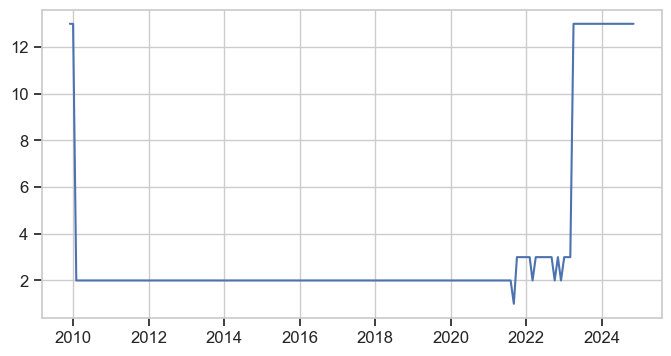

In [17]:
fig,ax = plt.subplots(figsize=(8,4))
plt.plot(inflation_rate.loc["2009-12-01":"2024-11-01"].index, bic_p)

#### Model Averaging

In [26]:
avar = pd.DataFrame(index=ar_forecasts.index, columns=pd.MultiIndex.from_product([["AvAR({1,13,25})", "AvAR({2,13,25})"], range(1, 13)]), dtype=float)
avar.loc[:, "AvAR({1,13,25})"] = (ar_forecasts["AR(1)"].to_numpy() + ar_forecasts["AR(13)"].to_numpy() + ar_forecasts["AR(25)"].to_numpy()) / 3
avar.loc[:, "AvAR({2,13,25})"] = (ar_forecasts["AR(2)"].to_numpy() + ar_forecasts["AR(13)"].to_numpy() + ar_forecasts["AR(25)"].to_numpy()) / 3
avar.to_csv("results/benchmarks/avar_forecasts.csv")
np.round(compute_rmse_df(avar).T, 2)

,1,2,3,4,5,6,7,8,9,10,11,12
"AvAR({1,13,25})",0.37,0.57,0.74,0.94,1.13,1.32,1.55,1.76,1.96,2.14,2.33,2.54
"AvAR({2,13,25})",0.37,0.57,0.74,0.93,1.13,1.32,1.54,1.75,1.95,2.12,2.31,2.51


## Random Walks

In [19]:
from methodology.rw_forecasts import rolling_rw_forecast

In [27]:
rw_forecasts = pd.concat([rolling_rw_forecast(inflation_rate, q=q, h=12, start="2009-12-01", end="2024-11-01") for q in [1, 4]], axis=1)
rw_forecasts.to_csv("results/benchmarks/rw_forecasts.csv")
np.round(compute_rmse_df(rw_forecasts).T, 2)

,1,2,3,4,5,6,7,8,9,10,11,12
RW(1),0.43,0.66,0.88,1.10,1.33,1.56,1.79,2.01,2.22,2.41,2.60,2.79
RW(4),0.73,0.96,1.19,1.42,1.65,1.87,2.08,2.28,2.48,2.66,2.84,3.00


## Bank of England

In [21]:
from methodology.bank_of_england import rmse_vs_bank, mape_vs_bank

In [28]:
np.round(rmse_vs_bank(avar).T, 2)

,1,2,3,4,5,6
BoE,0.173753,0.31743,0.484517,0.854409,0.929243,0.920107
"AvAR({1,13,25})",0.731368,0.887221,0.983087,1.084853,1.129389,1.082098
"AvAR({2,13,25})",0.721823,0.879979,0.975922,1.02584,1.061485,0.995331


In [29]:
np.round(mape_vs_bank(avar).T, 2)

,1,2,3,4,5,6
BoE,3.963889,7.075407,8.71433,8.244786,8.423779,9.581523
"AvAR({1,13,25})",12.463687,18.587589,15.326783,15.047872,14.802401,15.646697
"AvAR({2,13,25})",12.260634,18.699067,15.248258,14.439097,14.198918,14.825612
